In [54]:
import re
import sys
import os
import numpy as np
import scipy.signal as signal
import pandas as pd
from scipy.ndimage import uniform_filter
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy import cluster
from scipy.cluster.hierarchy import dendrogram
import uuid

from collections import defaultdict

import PCprophet.io_ as io
import PCprophet.stats_ as st




In [2]:
# generate empty dict
def makehash(w=dict):
    """autovivification like hash in perl
    http://stackoverflow.com/questions/651794/whats-the-best-way-to-initialize-a-dict-of-dicts-in-python
    use call it on hash like h = makehash()
    then directly
    h[1][2]= 3
    useful ONLY for a 2 level hash
    """
    # return defaultdict(makehash)
    return defaultdict(w)

# convert txt to dict
def read_txt(path, first_col="GN"):
    """
    read a tab delimited file giving a path and the first column name
    return a hash of hashes prot => sample => val
    """
    header = []
    HoA = makehash()
    temp = {}
    for line in open(path, "r"):
        line = line.rstrip("\n")
        if line.startswith(str(first_col) + "\t"):
            header = re.split(r"\t+", line)
        else:
            things = re.split(r"\t+", line)
            temp = dict(zip(header, things))
        if temp:
            HoA[temp.get("GN")] = []
            for key in header:
                try:
                    HoA[temp.get("GN")].append(float(temp[key]))
                except ValueError as v:
                    continue
    gene_count = len(HoA)
    #function is called twice -> two prints
    print(f"Number of analyzed genes in {path}: {gene_count}")
    return HoA

# standardize and center methods
def center_arr_mtd(hoa, fr_nr="all", smooth=True, stretch=(True, 72), resc=True):
    norm = {}
    for k in hoa:
        key = hoa[k]
        if fr_nr != "all":
            key = key[0:(fr_nr)]
        # if less than 2 real values
        if len([x for x in key if x > 0]) < 2:
            continue
        if smooth:
            key = st.gauss_filter(key, sigma=1, order=0)
        key = st.impute_namean(key)
        if stretch[0]:
            # input original length wanted length
            key = st.resample(key, len(key), output_fr=stretch[1])
        if resc:
            key = st.resize(key)
        norm[str.upper(k)] = list(key)
    return norm

In [3]:
infile = "..\\test\\test_frac.txt"
dat_dict = read_txt(path=infile)

Number of analyzed genes in ..\test\test_frac.txt: 47


No handles with labels found to put in legend.


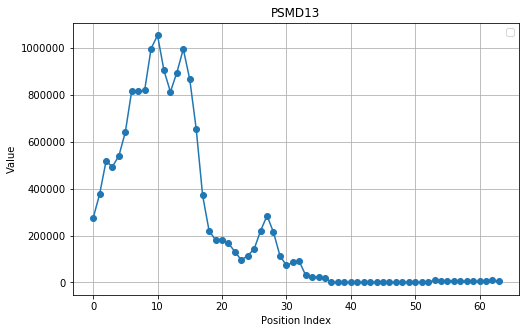

In [4]:
gene1 = next(iter(dat_dict))
dat_gene1 = dat_dict[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
dat_center = center_arr_mtd(dat_dict)

No handles with labels found to put in legend.


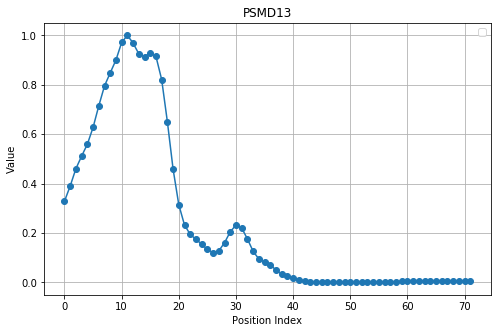

In [6]:
gene1 = next(iter(dat_center))
dat_gene1 = dat_center[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Position Index')
plt.ylabel('Value')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def center_arr_hyp(hoa, fr_nr="all", norm=True, nat=True, stretch=(True, 72)):
    hypo = {}
    for k in hoa:
        key = hoa[k]
        if fr_nr != "all":
            key = key[0:(fr_nr)]
        if len([x for x in key if x > 0]) < 2:
            continue
        key = st.gauss_filter(key, sigma=1, order=0)
        key = st.impute_namean(key)
        if stretch[0]:
            # input original length wanted length
            key = st.resample(key, len(key), output_fr=stretch[1])
        key = st.resize(key)
        hypo[k] = list(key)
    return hypo

def decondense(df, ids):
    """
    decondense a linkage matrix into all flat clusters
    """
    clusters = {}
    rows = cluster.hierarchy.linkage(df)
    lab = dict(zip(range(len(ids) + 1), ids))
    for row in range(rows.shape[0]):
        cluster_n = row + len(ids)
        glob1, glob2 = rows[row, 0], rows[row, 1]
        current = []
        for glob in [glob1, glob2]:
            if glob > (len(ids) - 1):
                current += clusters[glob]
            else:
                current.append(lab[int(glob)])
        clusters[cluster_n] = current
    return clusters

def fill_zeroes(prot, pk, left_base, right_base):
    """
    check left and right side of peaks and zero if >
    """
    arr = prot.copy()
    arr[:left_base] = [0 for aa in arr[:left_base]]
    arr[right_base:] = [0 for aa in arr[right_base:]]
    right = zero_sequence(arr[pk : len(arr)])
    left = zero_sequence(arr[:pk][::-1])[::-1]
    return left + right


def zero_sequence(arr):
    idx = 0
    k = True
    while k:
        # if we are at end return array
        if idx == len(arr) - 1:
            return arr
        # if current value smaller than next (i.e increasing)
        elif arr[idx] < arr[(idx + 1)]:
            # slice until there
            tmp = arr[:idx]
            l = [0] * (len(arr) - len(tmp))
            return tmp + l
        idx += 1

def split_peaks(prot_arr, pr, skp=0):
    """
    split peaks in n samples giving skp fractions of window
    returns
    'right_bases': array([32]), 'left_bases': array([7])
    """
    peaks = list(st.peak_picking(prot_arr))
    left_bases = peaks[1]["left_bases"]
    right_bases = peaks[1]["right_bases"]
    fr_peak = peaks[0]
    ret = {}
    # if no return value or 1 peak
    if len(fr_peak) < 2:
        ret[pr] = prot_arr
        return ret
    for idx, pk in enumerate(fr_peak):
        if pk < 6 and pk > 69:
            continue
        nm = "_".join([pr, str(idx)])
        clean = fill_zeroes(prot_arr, pk, left_bases[idx], right_bases[idx])
        ret[nm] = clean
    return ret


def format_cluster(hoa, clust):
    out = {}
    lk = {k: ",".join(map(str, v)) for k, v in hoa.items()}
    for gn in clust.values():
        if len(gn) > 1 and len(gn) <= 100:
            gn = [x if x in lk else re.sub("_\d+$", "", x) for x in gn]
            out["#".join(gn)] = ["#".join([lk[x] for x in gn])]
    return out

def collapse_prot(infile, use):
    prot = read_txt(infile, "GN")
    prot = center_arr_hyp(prot, fr_nr=use, stretch=(True, 72))
    prot2 = {}
    for pr in prot:
        pks = split_peaks(prot[pr], pr)
        if pks:
            for k in pks:
                prot2[k] = pks[k]
    pr_df = io.create_df(prot2)
    z = decondense(pr_df, list(pr_df.index))
    hypothesis = format_cluster(prot, z)
    hypo_df = pd.DataFrame.from_dict(hypothesis).T
    hypo_df["ID"] = ["cmplx_" + str(uuid.uuid4()) for x in list(hypo_df.index)]
    return hypo_df, pr_df



In [27]:
use_fr = "all"

hypo, df_s = collapse_prot(infile=infile, use=use_fr)
hypo.reset_index(inplace=True)
hypo.columns = ["MB", "FT", "ID"]
hypo = hypo[["ID", "MB", "FT"]]

Number of analyzed genes in ..\test\test_frac.txt: 47


No handles with labels found to put in legend.


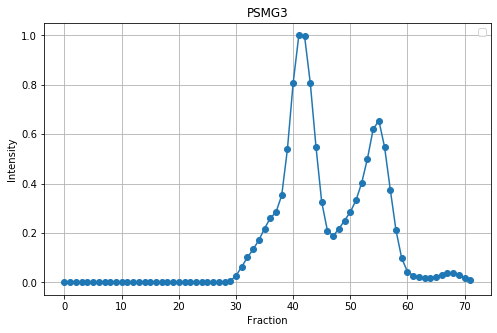

In [71]:
gene1 = 'PSMG3'
dat_gene1 = dat_center[gene1]
x_values = range(len(dat_gene1))  # Position indices

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(x_values, dat_gene1, marker='o', linestyle='-')
plt.xlabel('Fraction')
plt.ylabel('Intensity')
plt.title(f'{gene1}')
plt.grid(True)
plt.legend()
plt.show()

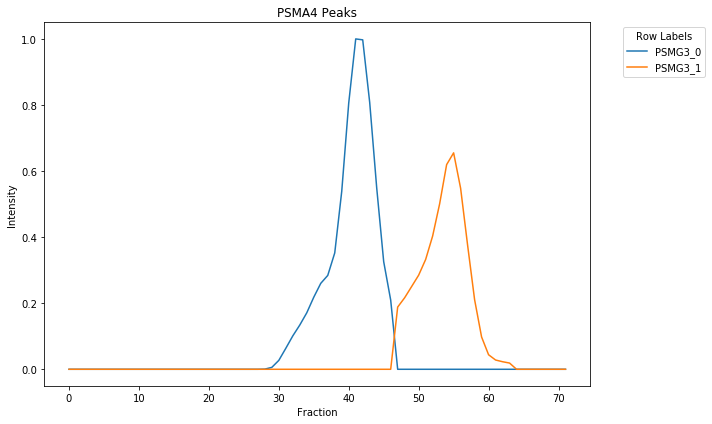

In [72]:
df_peaks_gene = df_s[df_s.index.str.contains(gene1)]

plt.figure(figsize=(10, 6))
for row_label, row_values in df_peaks_gene.iterrows():
    plt.plot(row_values, label=row_label)

# Customize the plot
plt.title('PSMA4 Peaks')
plt.xlabel('Fraction')
plt.ylabel('Intensity')
plt.legend(title='Row Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Probably a better idea to fit gaussians and define peaks like that?

In [45]:
cluster.hierarchy.linkage(df_s)

array([[4.20000000e+01, 6.70000000e+01, 1.19898232e-02, 2.00000000e+00],
       [8.00000000e+00, 5.20000000e+01, 1.24808406e-02, 2.00000000e+00],
       [5.60000000e+01, 7.10000000e+01, 2.09467292e-02, 2.00000000e+00],
       [6.90000000e+01, 9.90000000e+01, 2.34313969e-02, 3.00000000e+00],
       [7.30000000e+01, 1.00000000e+02, 2.43632268e-02, 3.00000000e+00],
       [5.40000000e+01, 6.40000000e+01, 2.58908229e-02, 2.00000000e+00],
       [1.03000000e+02, 1.04000000e+02, 2.62842405e-02, 5.00000000e+00],
       [1.01000000e+02, 1.05000000e+02, 2.93093575e-02, 7.00000000e+00],
       [3.70000000e+01, 7.20000000e+01, 2.97049742e-02, 2.00000000e+00],
       [3.60000000e+01, 1.06000000e+02, 3.23437807e-02, 8.00000000e+00],
       [8.50000000e+01, 1.08000000e+02, 3.30588290e-02, 9.00000000e+00],
       [9.00000000e+00, 5.70000000e+01, 4.34211061e-02, 2.00000000e+00],
       [1.00000000e+00, 8.90000000e+01, 4.51789544e-02, 2.00000000e+00],
       [7.40000000e+01, 1.10000000e+02, 4.67736351e

In [46]:
clusters = {}
ids = list(df_s.index)
rows = cluster.hierarchy.linkage(df_s)
lab = dict(zip(range(len(ids) + 1), ids))

dendrogram produces 99 leaves --> one per PEAK. not sure whether this behavior is wanted.

Also, if 

B C D is very rare and 

A B C is very abundant, the relative B C D peak in the B and C profiles will be very low and the A B C peak high while the B C D peak in in the D profile will be the only one and thus very high. So the peaks originating from the same complex will be very different in different relative intensity profiles - if this ends up leading to a dissimilar similarity metric, that would be a problem I think

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [75.0, 75.0, 85.0, 85.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [95.0, 95.0, 114.375, 114.375],
  [80.0, 80.0, 104.6875, 104.6875],
  [65.0, 65.0, 92.34375, 92.34375],
  [55.0, 55.0, 78.671875, 78.671875],
  [45.0, 45.0, 66.8359375, 66.8359375],
  [30.0, 30.0, 55.91796875, 55.91796875],
  [15.0, 15.0, 42.958984375, 42.958984375],
  [5.0, 5.0, 28.9794921875, 28.9794921875],
  [185.0, 185.0, 195.0, 195.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [235.0, 235.0, 245.0, 245.0],
  [265.0, 265.0, 275.0, 275.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [285.0, 285.0, 302.5, 302.5],
  [270.0, 270.0, 293.75, 293.75],
  [255.0, 255.0, 281.875, 281.875],
  [240.0, 240.0, 268.4375, 268.4375],
  [212.5, 212.5, 254.21875, 254.21875],
  [190.0, 190.0, 233.359375, 233.359375],
  [175.0, 175.0, 211.6796875, 211.6796875],


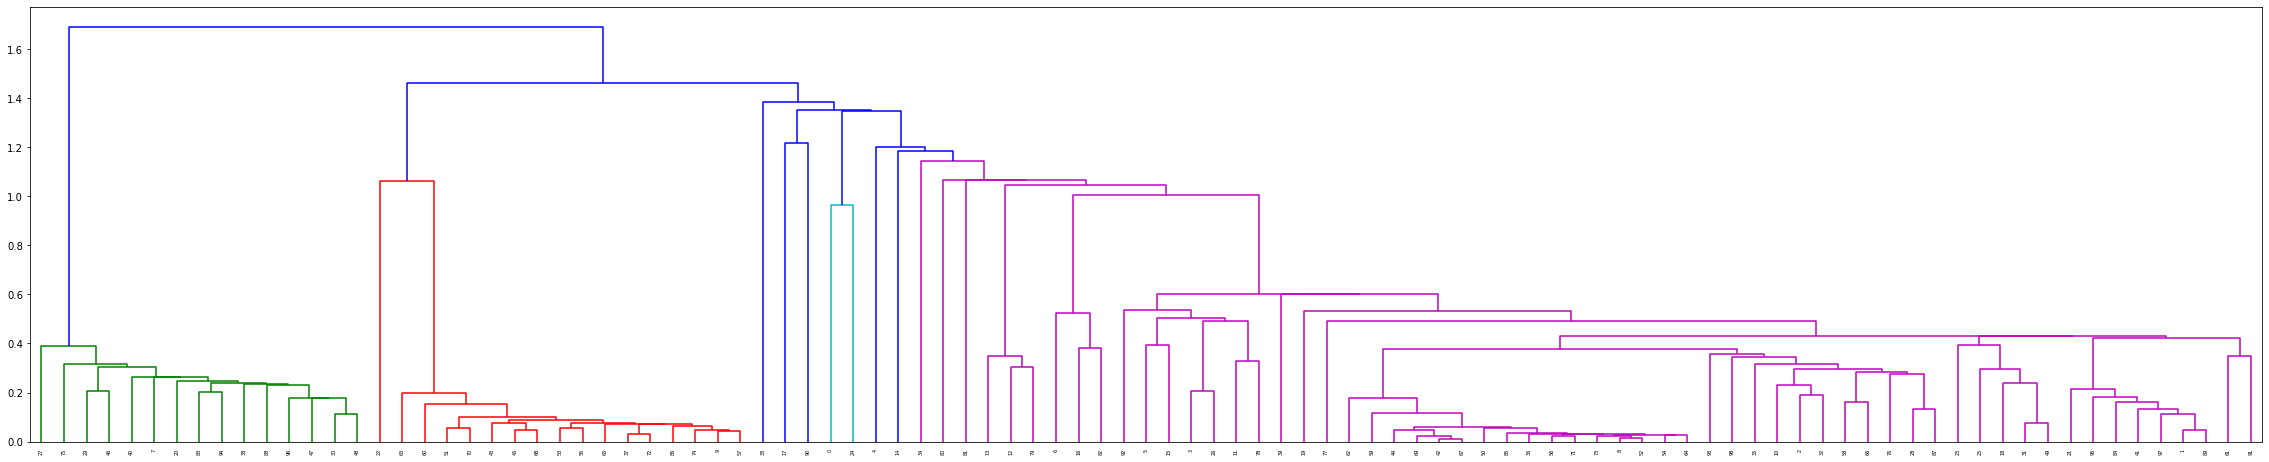

In [59]:
plt.figure(figsize=(40, 8))
dendrogram(rows)

(99, 99)


df_s contains 99 peaks for 47 proteins!

Condensed distance matrix shape: (4851,)


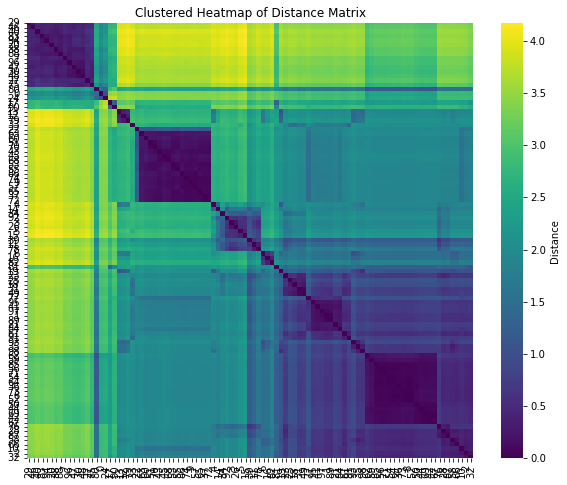

In [82]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute the condensed distance matrix
dist_matrix = pdist(df_s, metric='euclidean')  # Condensed vector
print("Condensed distance matrix shape:", dist_matrix.shape)

# Perform hierarchical clustering using the condensed distance matrix
linkage_result = linkage(dist_matrix, method='average')

# Create dendrogram to get ordering of rows/columns
dendro = dendrogram(linkage_result, no_plot=True)
ordered_indices = dendro['leaves']

# Convert condensed distance matrix to a square form
square_dist_matrix = squareform(dist_matrix)

# Reorder the square distance matrix based on the clustering
ordered_dist_matrix = square_dist_matrix[np.ix_(ordered_indices, ordered_indices)]

# Plot the clustered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_dist_matrix, 
            xticklabels=ordered_indices, 
            yticklabels=ordered_indices, 
            cmap='viridis', 
            annot=False,  # Set to False for larger datasets
            cbar_kws={'label': 'Distance'})
plt.title('Clustered Heatmap of Distance Matrix')
plt.show()
